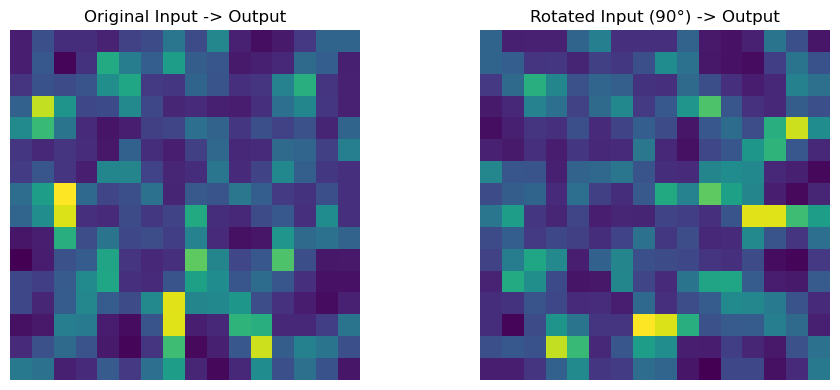

In [ ]:
import torch
import numpy as np
from escnn import gspaces
from escnn import nn as enn

import torch.nn as nn
import matplotlib.pyplot as plt

# Define the group and gspace for rotation equivariance
r2_act = gspaces.rot2dOnR2(N=8)  # 8-fold rotational symmetry

# Equivariant Linear Layer
class EquivariantLinear(enn.EquivariantModule):
    def __init__(self, in_type, out_type):
        super(EquivariantLinear, self).__init__()
        self.in_type = in_type
        self.out_type = out_type
        self.linear = enn.R2Conv(in_type, out_type, kernel_size=1, bias=True)
    
    def forward(self, x):
        return self.linear(x)
    
    def evaluate_output_shape(self, input_shape):
        return input_shape

# Equivariant Conv2D Layer
class EquivariantConv2D(enn.EquivariantModule):
    def __init__(self, in_type, out_type, kernel_size=3, padding=1):
        super(EquivariantConv2D, self).__init__()
        self.in_type = in_type
        self.out_type = out_type
        self.conv = enn.R2Conv(in_type, out_type, kernel_size=kernel_size, padding=padding)
    
    def forward(self, x):
        return self.conv(x)
    
    def evaluate_output_shape(self, input_shape):
        return input_shape

# Create field types
in_type = enn.FieldType(r2_act, [r2_act.trivial_repr])  # scalar field
hidden_type = enn.FieldType(r2_act, 4*[r2_act.regular_repr])  # 4 regular feature fields
out_type = enn.FieldType(r2_act, [r2_act.trivial_repr])  # scalar output

# Build equivariant network
model = enn.SequentialModule(
    EquivariantConv2D(in_type, hidden_type, kernel_size=3, padding=1),
    enn.ReLU(hidden_type),
    EquivariantConv2D(hidden_type, hidden_type, kernel_size=3, padding=1),
    enn.ReLU(hidden_type),
    EquivariantLinear(hidden_type, out_type)
)
def test_rotation_equivariance():
    # Create test input
    x = torch.randn(1, 1, 16, 16)
    x_geom = enn.GeometricTensor(x, in_type)
    
    # Forward pass on original input
    y1 = model(x_geom)
    
    # Use discrete rotation index instead of continuous angle
    # For N=8: 0=0°, 1=45°, 2=90°, 3=135°, etc.
    rotation_index = 2  # This is 45 degrees for N=8
    x_rotated = x_geom.transform(r2_act.fibergroup.element(rotation_index))
    
    # Forward pass on rotated input
    y2_rotated = model(x_rotated)
    
    y2_revert_rotated = y2_rotated.transform(r2_act.fibergroup.element(-rotation_index))

    fig, (ax1, ax2) = plt.subplots(1, 3, figsize=(10, 4))
    
    ax1.imshow(y1.tensor[0, 0].detach().numpy(), cmap='viridis')
    ax1.set_title('Original Input -> Output')
    ax1.axis('off')
    
    ax2.imshow(y2_rotated.tensor[0, 0].detach().numpy(), cmap='viridis')
    ax2.set_title('Rotated Input (90°) -> Output')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


def visualize_rotation_test():
    x = torch.randn(1, 1, 16, 16)
    x_geom = enn.GeometricTensor(x, in_type)
    
    # Rotate by 90 degrees = index 2 for N=8
    rotation_index = 2  # 90 degrees
    x_rotated = x_geom.transform(r2_act.fibergroup.element(rotation_index))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.imshow(x[0, 0].detach().numpy(), cmap='viridis')
    ax1.set_title('Original Input')
    ax1.axis('off')
    
    ax2.imshow(x_rotated.tensor[0, 0].detach().numpy(), cmap='viridis')
    ax2.set_title('Rotated Input (90°)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
test_rotation_equivariance()
# visualize_rotation_test()